# CASE BASED CLASSIFICATION

This notebook develops the idea of case base classiication (cb-clf). This involves:
1. Identify sets of feature that provide good classification accuracy. There may be many.
1. Given a new feature vector, provide evidence for the difference classes to which it may belong.

A **feature** is an atribtue of the data, like a Gene. A feature set is a collection of genes.
We typically write this as Rv3246c+Rv3260c.

A **feature vector** is a set of features with a value assigned. We are dealing with trinary values: -1 (under expressed),
+1 (over expressed), 0 (otherwise).
We typically write this as
Rv3246c[-1]+Rv3260c[0].

A **case** is a feature vector that effectively distinguishes between expression states (classes).

Cases are obtained from decision trees by examining nodes to see if their *impurity* (class distinctions) are statistically
significant.

Decision trees are obtained by running the Random Forest Classsification Algorithm.
This is done separately for each expression state.
So, in our data, there are 6 sets of cases.

Classifications are evaluated for new gene expression data by:
* Setup
   1. Construct cases for each expression state.
   
* Evaluation of a data set
   1. Create trinary data
   1. For each expression state
      1. Find applicable cases
      1. Plot their significance level

## Imports

In [1]:
import init
import common.constants as cn
import common_python.constants as ccn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import feature_analyzer
from common_python.classifier import feature_set_collection
from common_python.util import util
from common import transform_data
from common_python.classifier.feature_set import FeatureSet
from common import trinary_data
from common_python.classifier.case_manager import FeatureVectorStatistic, Case, CaseManager
from common_python.classifier.case_manager_collection import CaseManagerCollection

import copy
import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

%matplotlib inline

## Constants

In [2]:
# These are the "long" data that have individual replications, not averages. And, only using TFs.
TRINARY = TrinaryData(is_averaged=False, is_dropT1=False, is_regulator=True)  # Trinary data
PROVIDER = DataProvider()
PROVIDER.do()
DF_X = TRINARY.df_X
SER_Y = TRINARY.ser_y
STATES = SER_Y.unique()
FEATURES_NAMES = DF_X.columns.tolist()
NUM_TREE = 300
SER_DESC = PROVIDER.df_go_terms.set_index(cn.GENE_ID)
SER_DESC = SER_DESC["GO_Term"]

## Data

1. The data consistent of individual replicas of read counts at 26 times.
1. Times are labelled with six states, as defined in ``STATE_DCT``.
1. Raw expression values of normalized w.r.t. time 0 (normal) and transformed as log2 so that there are
25 normalized times that are trinary values defined as:
   * -1 if < -1
   * 1 if > 1
   * 0 otherwise

In [3]:
SER_DESC.head(4)

GENE_ID
P9WKY5                                    host cell nucleus
Rv0001    DNA replication initiation---dephosphorylation...
Rv0002                     extracellular region---cell wall
Rv0003    double-strand break repair---cytosol---plasma ...
Name: GO_Term, dtype: object

In [4]:
sel = [(g in DF_X.columns) and (SER_DESC.loc[g].find("fatty acid") > 0) for g in SER_DESC.index]
SER_DESC[sel]

GENE_ID
Rv0117     regulation of fatty acid metabolic process---r...
Rv0445c    regulation of gene expression---regulation of ...
Rv1359     regulation of gene expression---regulation of ...
Rv1956     response to hypoxia---regulation of fatty acid...
Rv2017     regulation of fatty acid metabolic process---r...
Rv2021c    regulation of fatty acid metabolic process---r...
Rv2034     regulation of transcriptionDNA-templated---reg...
Rv2745c    response to oxidative stress---response to hea...
Rv3133c    response to hypoxia---pathogenesis---regulatio...
Rv3164c    regulation of fatty acid metabolic process---c...
Rv3414c    pathogenesis---response to heat---regulation o...
Rv3416     pathogenesis---regulation of lipid metabolic p...
Rv3557c    regulation of transcriptionDNA-templated---reg...
Rv3833     regulation of fatty acid metabolic process---m...
Name: GO_Term, dtype: object

In [5]:
STATE_DCT = {}
STATE_DCT[0] = "Normoxia"
STATE_DCT[1] = "Transition"
STATE_DCT[2] = "Stage II"
STATE_DCT[3] = "Stage 1a"
STATE_DCT[4] = "Stage 1b"
STATE_DCT[5] = "Resuscitation"
STATE_DCT

{0: 'Normoxia',
 1: 'Transition',
 2: 'Stage II',
 3: 'Stage 1a',
 4: 'Stage 1b',
 5: 'Resuscitation'}

In [6]:
CASE_MANAGER_COLLECTION_BASE = CaseManagerCollection(DF_X, SER_Y, n_estimators=NUM_TREE)
CASE_MANAGER_COLLECTION_BASE.build()

In [7]:
SAMPLE_DATA = trinary_data.getSampleData()
DF_AM_MDM = SAMPLE_DATA.AM_MDM.T
DF_AW = SAMPLE_DATA.AW.T
DF_GALAGAN = SAMPLE_DATA.galagan.T
DF_SHERMAN = SAMPLE_DATA.sherman.T
DF_RUSTAD = SAMPLE_DATA.rustad.T

In [8]:
DF_AW

,AW_plus_1,AW_neg_1,AW_plus_3,AW_neg_3,AW_plus_4,AW_neg_4
GENE_ID,,,,,,
Rv3830c,-1,-1,-1,0,-1,0
Rv1332,1,1,0,1,1,0
Rv3160c,0,1,0,0,1,0
Rv3164c,0,1,1,1,1,0
Rv1404,0,0,1,0,1,0
...,...,...,...,...,...,...
Rv1675c,-1,-1,-1,-1,-1,-1
Rv1657,-1,-1,-1,-1,-1,-1
Rv1379,0,-1,-1,-1,-1,-1


## Helper Functions

In [ ]:
 def oldFullProfile(ser_X, title="", max_sl=0.001, **kwargs):
        """
        Creates a classification profile for the feature vector.
        
        Parameters
        ----------
        ser_X: Series (feature vector)
        """
        kwargs["max_sl"] = max_sl
        num_row = 2 
        num_col = 3 
        fig, axes = plt.subplots(num_row, num_col,
            figsize=(16, 10))
        for idx, state in enumerate(STATES):
            row = int(idx/num_col)
            col = idx % num_col
            manager = CASE_MANAGER_DCT[state]
            if row == 0:
                label_xoffset = -0.1
            else:
                label_xoffset = 0.1 
            cases = manager.plotEvaluate(ser_X, 
                ax=axes[row, col], is_plot=False,
                title = STATE_DCT[idx],
                label_xoffset=label_xoffset, **kwargs)
        fig.suptitle(title, fontsize=16)
        plt.show()
        
# Tests
ser_X = DF_X.loc["T2.1"]
oldFullProfile(ser_X, max_sl=0.001)

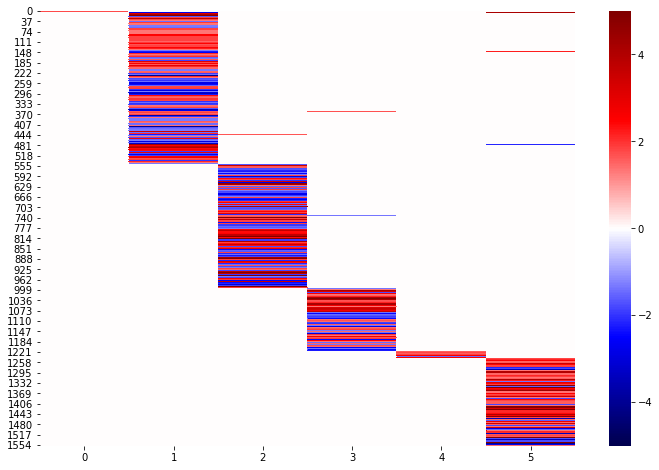

In [11]:
def fullProfile(collection, ser_X, title="", max_sl=5, include_terms=None, **kwargs):
    """
    Creates a classification profile for the feature vector.

    Parameters
    ----------
    ser_X: Series (feature vector)
    """
    kwargs["max_sl"] = max_sl
    if include_terms is not None:
        for manager in collection.manager_dct.values():
            manager.filterCaseByDescription(ser_desc, include_terms=terms)
    df = collection.plotHeatmap(is_plot=True, **kwargs)

# TESTING
collection = copy.deepcopy(CASE_MANAGER_COLLECTION_BASE)
ser_X = DF_X.loc["T2.1"]
fullProfile(collection, ser_X, figsize=(12, 8))

# Miscellaneous Calculations

## Case Calculations

Given a maximum significance level $\alpha$, a sample size of $N$, and null distribution that is Binomial in $(N, p)$,
what is the minimum sample size?

We want $N$ such that $P(n = N) = P(n = 0) \leq \alpha$.
That is, $\alpha \geq p^N \equiv \frac{log(\alpha)}{log(p)} \leq N$.

# Evaluations of Samples - Only "fatty acid" + "hypoxia"

In [ ]:
CASE_MANAGER_DCT = copy.deepcopy(CASE_MANAGER_BASE_DCT)

In [ ]:
[m.filterCaseByDescription(SER_DESC, include_terms=["hypoxia", "fatty acid"]) for m in CASE_MANAGER_DCT.values()]
{k: len(CASE_MANAGER_DCT[k].case_dct) for k in CASE_MANAGER_DCT}

## Training Data

A feature vector evaluation involves finding all cases that apply to the feature vector
and indicating their support for or against a particular state.

In [ ]:
# Below is a evaluation of the feature vector at the first replication at time T3.
instances = ["T3.0", "T3.1", "T3.2"]
for instance in instances:
    fullProfile(DF_X.loc[instance], title=instance)

In [ ]:
instances = ["T13.0", "T13.1", "T13.2"]
for instance in instances:
    fullProfile(DF_X.loc[instance], title=instance)

## AW

In [ ]:
DF_AW.head(2)

In [ ]:
instances = [ ["AW_%s_%d" % (pm, n) for pm in ["plus", "neg"]] for n in [1, 3, 4]]
instances = list(np.array(instances).flatten())
for instance in instances:
    fullProfile(DF_AW[instance], title=instance)

## AM, MDM

In [ ]:
DF_AM_MDM.head(2)

In [ ]:
instances = [ ["%s_D20_%d" % (pm, n) for pm in ["AM", "MDM"]] for n in [1, 3, 4, 5]]
instances = list(np.array(instances).flatten())
for instance in instances:
    fullProfile(DF_AM_MDM[instance], title=instance)

## Galagan

In [ ]:
DF_GALAGAN.head(2)

In [ ]:
for instance in DF_GALAGAN.columns:
    fullProfile(DF_GALAGAN[instance], title=instance)

## Sherman

In [ ]:
DF_SHERMAN.head(2)

In [ ]:
fullProfile(DF_SHERMAN[0], title="Sherman")

## Rustad

In [ ]:
DF_RUSTAD.head(2)

In [ ]:
for instance in DF_RUSTAD.columns:
    fullProfile(DF_RUSTAD[instance], title=instance)

# Evaluations of Samples - Only "hypoxia"

In [ ]:
CASE_MANAGER_DCT = copy.deepcopy(CASE_MANAGER_BASE_DCT)

In [ ]:
[m.filterCaseByDescription(SER_DESC, include_terms=["hypoxia"]) for m in CASE_MANAGER_DCT.values()]
{k: len(CASE_MANAGER_DCT[k].case_dct) for k in CASE_MANAGER_DCT}

## Training Data

In [ ]:
# Below is a evaluation of the feature vector at the first replication at time T3.
instances = ["T3.0", "T3.1", "T3.2"]
for instance in instances:
    fullProfile(DF_X.loc[instance], title=instance)

In [ ]:
instances = ["T13.0", "T13.1", "T13.2"]
for instance in instances:
    fullProfile(DF_X.loc[instance], title=instance)
print("State: %s" % STATE_DCT[SER_Y.loc["T13.0"]])

## AW

In [ ]:
instances = [ ["AW_%s_%d" % (pm, n) for pm in ["plus", "neg"]] for n in [1, 3, 4]]
instances = list(np.array(instances).flatten())
for instance in instances:
    fullProfile(DF_AW[instance], title=instance)

## AM, MDM

In [ ]:
instances = [ ["%s_D20_%d" % (pm, n) for pm in ["AM", "MDM"]] for n in [1, 3, 4, 5]]
instances = list(np.array(instances).flatten())
for instance in instances:
    fullProfile(DF_AM_MDM[instance], title=instance)

# Next Steps

1. Use other criteria to select the cases
   1. Prefer longer feature vectors since more specific
   1. Prefer cases that have a gene with a "hypoxia" GO term. Subset the cases to include genes for hypoxia and fatty acid.
   1. Aggregate terms if the same features appear repeatedly (e.g., only include a term if it's extension is not significant?)